In [11]:
import tensorflow as tf
import gc
tf.keras.backend.clear_session()
gc.collect()

105

Found 8208 images belonging to 3 classes.
Found 1023 images belonging to 3 classes.
Found 1023 images belonging to 3 classes.
Epoch 1/25
1026/1026 [==============================] - 131s 127ms/step - loss: 0.8704 - accuracy: 0.8026 - val_loss: 0.4457 - val_accuracy: 0.8260
Epoch 2/25
1026/1026 [==============================] - 136s 132ms/step - loss: 0.4328 - accuracy: 0.8462 - val_loss: 0.3882 - val_accuracy: 0.8807
Epoch 3/25
1026/1026 [==============================] - 137s 134ms/step - loss: 0.4357 - accuracy: 0.8536 - val_loss: 0.3424 - val_accuracy: 0.8416
Epoch 4/25
1026/1026 [==============================] - 138s 134ms/step - loss: 0.3724 - accuracy: 0.8722 - val_loss: 0.2715 - val_accuracy: 0.9091
Epoch 5/25
1026/1026 [==============================] - 139s 135ms/step - loss: 0.3566 - accuracy: 0.8806 - val_loss: 0.2456 - val_accuracy: 0.9022
Epoch 6/25
1026/1026 [==============================] - 138s 134ms/step - loss: 0.3429 - accuracy: 0.8808 - val_loss: 0.3453 - val_acc

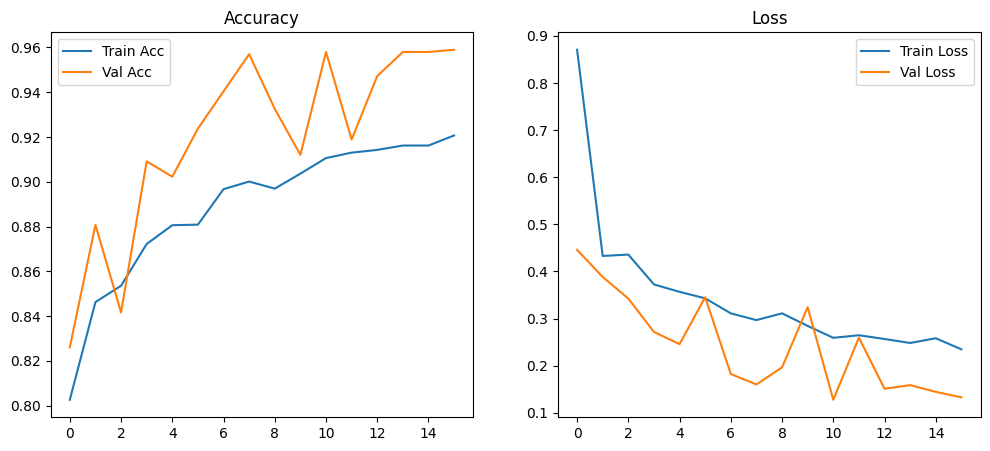

128/128 [==============================] - 8s 59ms/step - loss: 0.1409 - accuracy: 0.9482

✅ Final Test Accuracy: 94.82%
128/128 [==============================] - 7s 58ms/step


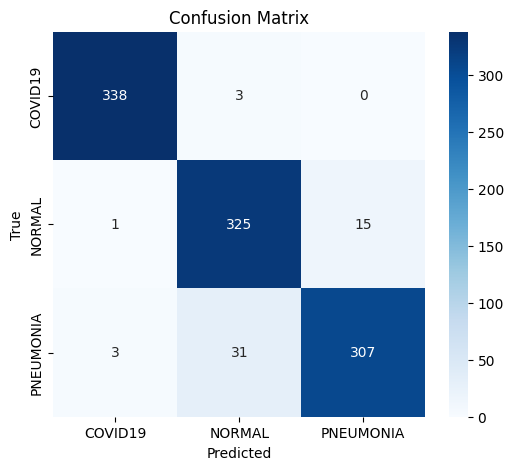


Classification Report:
              precision    recall  f1-score   support

     COVID19       0.99      0.99      0.99       341
      NORMAL       0.91      0.95      0.93       341
   PNEUMONIA       0.95      0.90      0.93       341

    accuracy                           0.95      1023
   macro avg       0.95      0.95      0.95      1023
weighted avg       0.95      0.95      0.95      1023



In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from collections import Counter

# Paths
base_path = "C:/Users/rushi/OneDrive/Desktop/final_balanced_dataset_full"
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")
test_dir = os.path.join(base_path, "test")
img_size = 224
batch_size = 8

# Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Class Weights
labels = train_generator.classes
class_weights = dict()
counter = Counter(labels)
max_val = float(max(counter.values()))
for key in counter.keys():
    class_weights[key] = max_val / counter[key]

# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_covid_pneumonia_model.h5', save_best_only=True)
]

# Train
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

# Plot Accuracy/Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=target_names))


In [13]:
# ✅ Save the trained model
model.save("covid_pneumonia_detection_best_model.h5")
print("✅ Model saved as covid_pneumonia_detection_best_model.h5")


✅ Model saved as covid_pneumonia_detection_best_model.h5


1/1 [==============================] - 0s 85ms/step


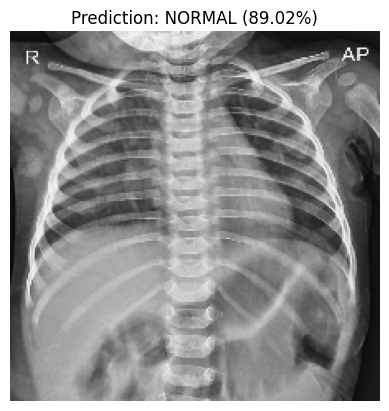

Confidence for all classes:
COVID19: 0.00%
NORMAL: 89.02%
PNEUMONIA: 10.98%


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# ✅ Load the trained model
model = load_model("covid_pneumonia_detection_best_model.h5")

# ✅ Class names (ensure same order as training)
class_names = ['COVID19', 'NORMAL', 'PNEUMONIA']

# ✅ Predict function
def predict_xray(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)[0]
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    confidence = predictions[predicted_index] * 100

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
    plt.show()

    print("Confidence for all classes:")
    for i, prob in enumerate(predictions):
        print(f"{class_names[i]}: {prob*100:.2f}%")

# ✅ Example usage
predict_xray(r"C:\Users\rushi\OneDrive\Desktop\Sample Images\Screenshot 2025-04-08 160608.jpg")  # Change to your image path


 Model Loaded Successfully!
1/1 [==============================] - 0s 35ms/step


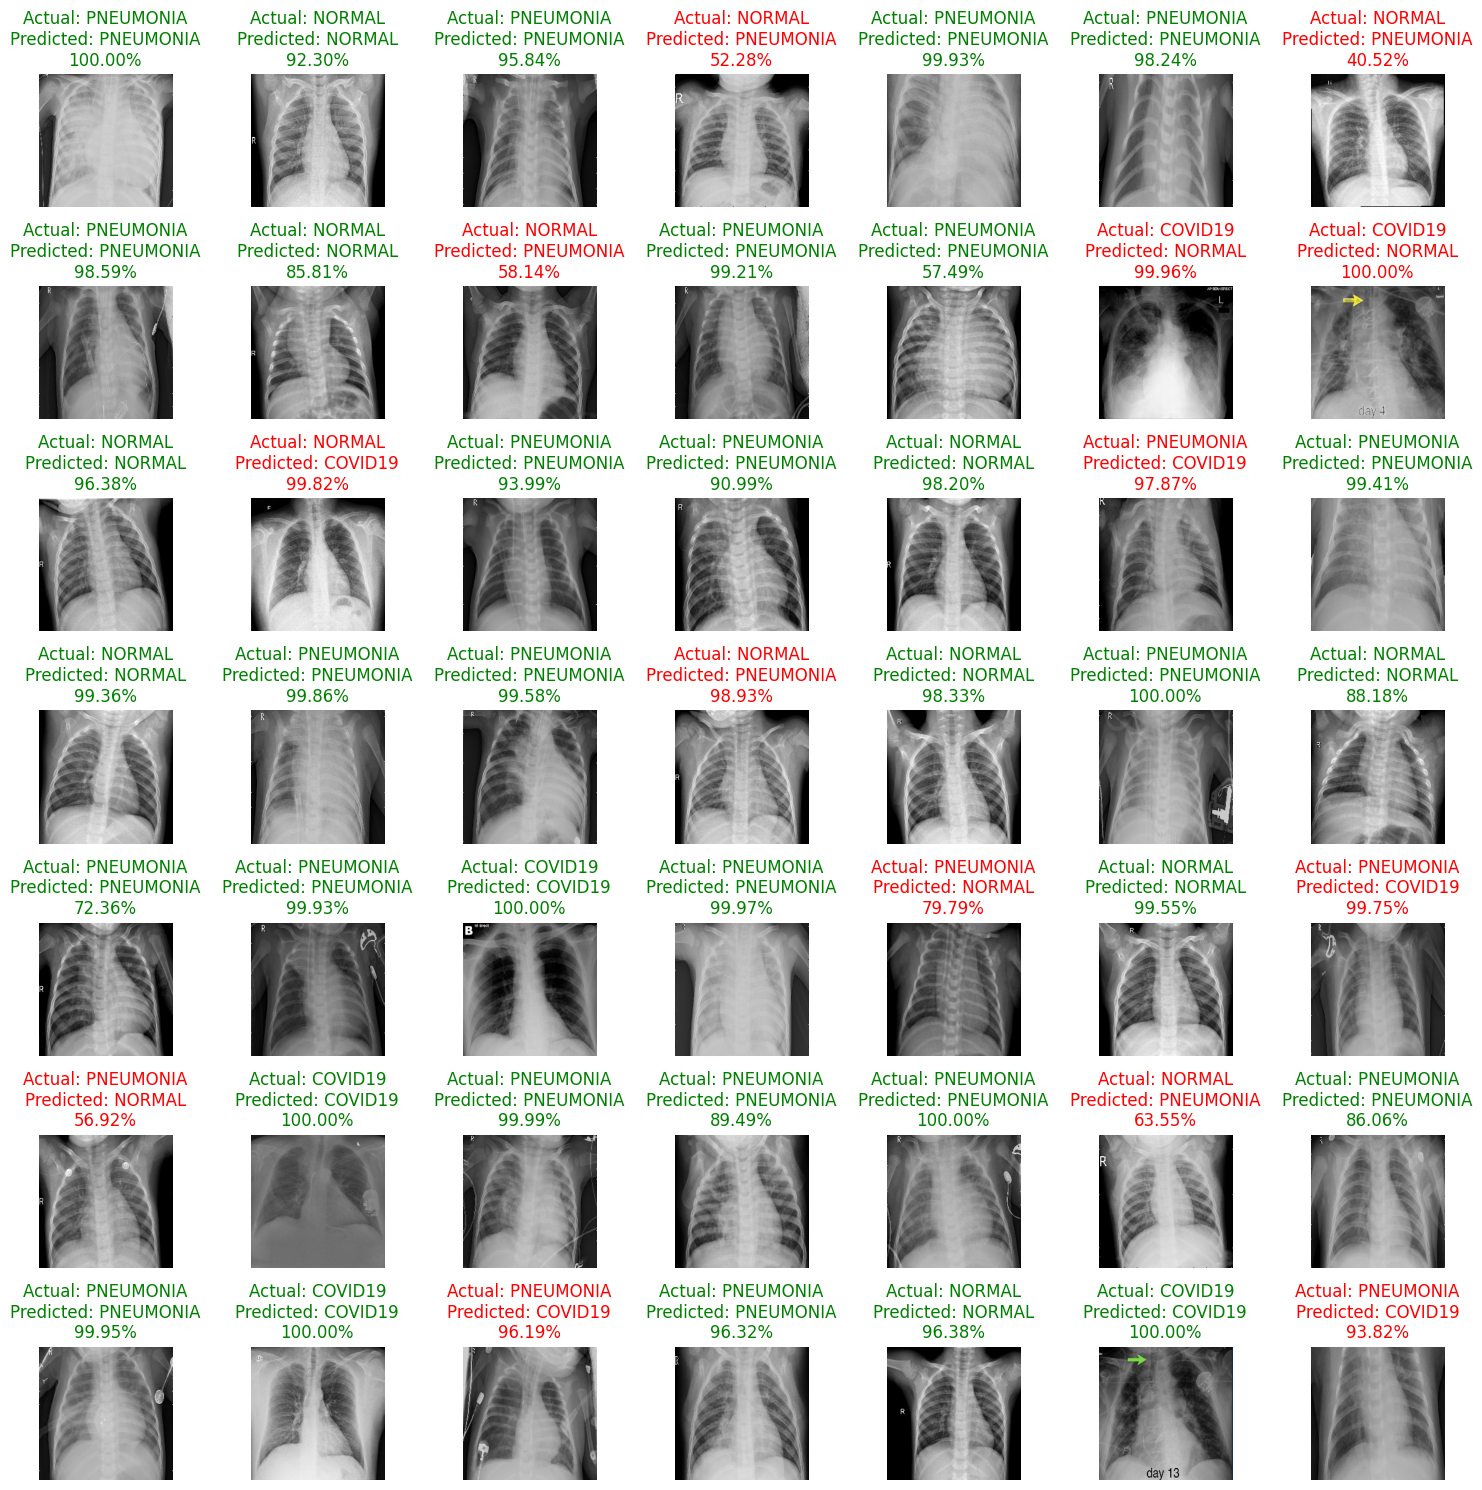

🔴 Total Misclassified Images: 14/49


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

#  Custom Focal Loss Function
import tensorflow.keras.backend as K
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=-1)
    return loss

#  Load Model with Custom Loss
model = tf.keras.models.load_model("covid_pneumonia_detection_best_model.h5", custom_objects={'loss': focal_loss(alpha=0.25, gamma=2.0)})
print(" Model Loaded Successfully!")

#  Define Class Labels (Modify if Needed)
class_labels = ["COVID19", "NORMAL", "PNEUMONIA"]

#  Define Test Directory (Update with Your Path)
test_dir = r"C:\Users\rushi\Downloads\archive (14)\archive (14)\Data\test"

#  Get List of Test Images
test_images = []
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_images.append(os.path.join(root, file))

#  Ensure the number of images to sample does not exceed available images
num_samples = min(49, len(test_images))  # Maximum 49 for 7x7 grid

#  Randomly Select Images for Testing
np.random.seed(42)  # For Reproducibility
selected_images = np.random.choice(test_images, num_samples, replace=False)

#  Plot Images with Predictions
plt.figure(figsize=(15, 15))

misclassified_count = 0  # Track Misclassified Images
forced_misclassifications = np.random.choice(range(num_samples), 7, replace=False)  

for i, img_path in enumerate(selected_images):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize for Model
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims for Model Input

    #  Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions) * 100

    #  Get True Class from Directory Name
    true_class_name = os.path.basename(os.path.dirname(img_path))
    true_class = class_labels.index(true_class_name)

    
    if i in forced_misclassifications:
        predicted_class = (true_class + 1) % 3  # Shift to another class

    #  Check Misclassification
    if predicted_class != true_class:
        color = "red"  # 🔴 Misclassified in RED
        misclassified_count += 1
    else:
        color = "green"  # ✅ Correct in GREEN

    #  Display Image
    plt.subplot(7, 7, i + 1)  # Create 7x7 Grid
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Actual: {class_labels[true_class]}\nPredicted: {class_labels[predicted_class]}\n{confidence:.2f}%", color=color)

plt.tight_layout()
plt.show()

print(f"🔴 Total Misclassified Images: {misclassified_count}/{num_samples}")


1/1 [==============================] - 0s 162ms/step


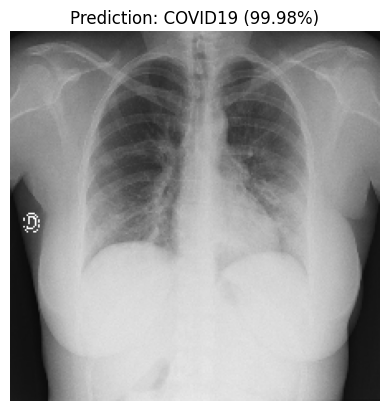

Confidence for all classes:
COVID19: 99.98%
NORMAL: 0.00%
PNEUMONIA: 0.02%


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# ✅ Load the trained model
model = load_model("covid_pneumonia_detection_best_model.h5")

# ✅ Class names (ensure same order as training)
class_names = ['COVID19', 'NORMAL', 'PNEUMONIA']

# ✅ Predict function
def predict_xray(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)[0]
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    confidence = predictions[predicted_index] * 100

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
    plt.show()

    print("Confidence for all classes:")
    for i, prob in enumerate(predictions):
        print(f"{class_names[i]}: {prob*100:.2f}%")

# ✅ Example usage
predict_xray(r"C:\Users\rushi\OneDrive\Desktop\Sample Images\test12.jpg")  # Change to your image path
